Image shape: (512, 512, 3) dtype: uint8
Decoded identical to original: True
Number of runs: 1
Compression ratio: 37449.143


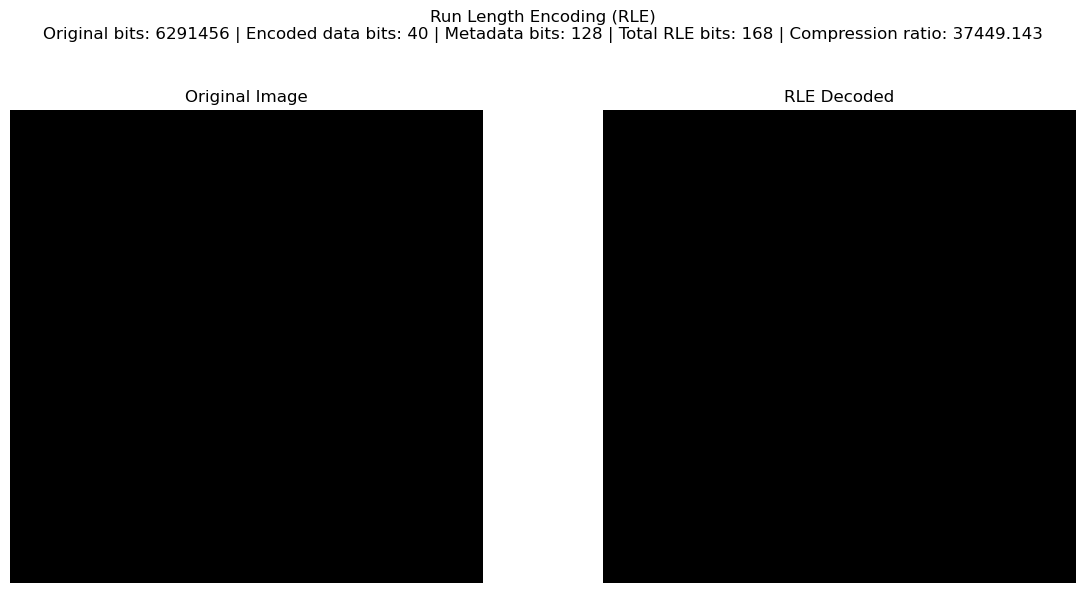

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Run Length Encoding (RLE) ---------------- #

def rle_encode(img):
    flat = img.flatten()
    encoded = []
    
    if len(flat) == 0:
        return encoded, img.shape, img.dtype
    
    current_val = flat[0]
    count = 1
    
    for val in flat[1:]:
        if val == current_val:
            count += 1
        else:
            encoded.append((current_val, count))
            current_val = val
            count = 1
    
    # Append the last run
    encoded.append((current_val, count))
    
    return encoded, img.shape, img.dtype


def rle_decode(encoded, shape, dtype):
    decoded_vals = []
    
    for val, count in encoded:
        decoded_vals.extend([val] * count)
    
    return np.array(decoded_vals, dtype=dtype).reshape(shape)


# ---------------- Compression Ratio Calculation ---------------- #

def calculate_rle_compression_ratio(img):
    """
    Calculate compression ratio for RLE encoding.
    
    Args:
        img: input image (numpy array)
    
    Returns:
        tuple: (compression_ratio, orig_bits, encoded_bits, metadata_bits, 
                total_bits, encoded_data)
    """
    # Original size in bits
    orig_bits = img.nbytes * 8
    
    # Encode the image
    encoded, shape, dtype = rle_encode(img)
    
    # Calculate encoded data size
    # Each run is (value, count) where:
    # - value: same size as original dtype
    # - count: we'll use 32 bits (int32) to store counts
    bytes_per_pixel = img.dtype.itemsize
    encoded_bits = len(encoded) * (bytes_per_pixel * 8 + 32)
    
    # Metadata: shape (3 or 2 dimensions * 32 bits) + dtype info (32 bits)
    metadata_bits = len(shape) * 32 + 32
    
    total_bits = encoded_bits + metadata_bits
    compression_ratio = orig_bits / total_bits if total_bits > 0 else 0
    
    return compression_ratio, orig_bits, encoded_bits, metadata_bits, total_bits, encoded, shape, dtype


# ---------------- Visualization ---------------- #

def display_side_by_side(original, decoded, ratio, orig_bits, encoded_bits, metadata_bits, total_bits):
    """
    Display original and decoded images side by side with compression statistics.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display original image
    if len(original.shape) == 3:  # RGB
        axes[0].imshow(np.clip(original, 0, 1) if np.issubdtype(original.dtype, np.floating) else original)
    else:  # Grayscale
        axes[0].imshow(original, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Display decoded image
    if len(decoded.shape) == 3:  # RGB
        axes[1].imshow(np.clip(decoded, 0, 1) if np.issubdtype(decoded.dtype, np.floating) else decoded)
    else:  # Grayscale
        axes[1].imshow(decoded, cmap='gray')
    axes[1].set_title("RLE Decoded")
    axes[1].axis("off")
    
    plt.suptitle(
        f"Run Length Encoding (RLE)\n"
        f"Original bits: {orig_bits} | "
        f"Encoded data bits: {encoded_bits} | "
        f"Metadata bits: {metadata_bits} | "
        f"Total RLE bits: {total_bits} | "
        f"Compression ratio: {ratio:.3f}",
        fontsize=12
    )
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


# ---------------- Example Usage ---------------- #

if __name__ == "__main__":
    import matplotlib.image as mpimg
    
    # Load image
    # img = mpimg.imread("/mnt/769EC2439EC1FB9D/vsc_projs/DIP/samples/kodak/kodim20.png")  # REPLACE WITH YOUR IMAGE PATH
    img = np.zeros((512,512,3))
    
    # Convert float images to uint8 for better compression
    if img.dtype in [np.float32, np.float64]:
        img = (img * 255).astype(np.uint8)
    
    print("Image shape:", img.shape, "dtype:", img.dtype)
    
    # Calculate compression ratio
    ratio, orig_bits, encoded_bits, metadata_bits, total_bits, encoded, shape, dtype = \
        calculate_rle_compression_ratio(img)
    
    # Decode the image
    decoded = rle_decode(encoded, shape, dtype)
    
    # Verify decoding
    print(f"Decoded identical to original: {np.array_equal(img, decoded)}")
    print(f"Number of runs: {len(encoded)}")
    print(f"Compression ratio: {ratio:.3f}")
    
    if ratio < 1.0:
        print(f"Warning: RLE resulted in expansion (ratio < 1). "
              f"RLE works best on images with many repeated values.")
    
    # Display results
    display_side_by_side(img, decoded, ratio, orig_bits, encoded_bits, metadata_bits, total_bits)